# Data prepare 

This segment prepares dataset containig normalized sound recordings extended with temperature and humidity values. For now we support only one hive for data preparation.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
# 1300001 - hive
# 1300002 - not hive?
# 1400001 - hive szymanski
# 1400002 - hive szymanski
#hives_ids = [1300001, 1300002, 1400001, 1400002]

hives_ids = [1300001]
DATA_INIT = True

In [ ]:
if DATA_INIT:
    dfh_hives = [pd.read_csv(f"measurements/{hive_id}/humidity.csv") for hive_id in hives_ids]
    dft_hives = [pd.read_csv(f"measurements/{hive_id}/temperature.csv") for hive_id in hives_ids]
    dfh_hivesWithoutDuplicates = [dfh_hive.drop_duplicates(subset=['timestamp'], keep=False) for dfh_hive in dfh_hives]
    dft_hivesWithoutDuplicates = [dft_hive.drop_duplicates(subset=['timestamp'], keep=False) for dft_hive in dft_hives]

    for idx, hive_id in enumerate(hives_ids):
        print(f"Hive no. {hives_ids[idx]} | humidity temperature dataset size : {dfh_hivesWithoutDuplicates[idx].shape} {dft_hivesWithoutDuplicates[idx].shape}")

    df_hive = [pd.merge(
        dfh_hivesWithoutDuplicates[idx], dft_hivesWithoutDuplicates[idx], on='timestamp', suffixes=(f"_humidity_{hive_id}",f"_temperature_{hive_id}"))
               for idx, hive_id in enumerate(hives_ids)]

    
    total = 0
    for atmosphere_data in df_hive:
        atmosphere_data['timestamp'] = pd.to_datetime(atmosphere_data['timestamp'], format='%Y-%m-%dT%H-%M-%S').sort_values()
        atmosphere_data.set_index('timestamp', inplace=True)
        print(f"Atmospheric data after merge: {atmosphere_data.shape}")
        total += atmosphere_data.shape[0]
    
    print(f"Total atmoshpere dataset size: {total}")

In [ ]:
import glob 

if DATA_INIT:
    hive_sounds = []
    hive_timestamps = []
    for idx, hive_id in enumerate(hives_ids):
        print(f"Data preparation for hive: {hive_id}")

        sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        sound_hive_list = []
        for file in tqdm(sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples['samples'].values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                #np_samples = scaler.fit_transform(np_samples.reshape(-1, 1))
                hive_sounds.append([pd_timestamp, np_samples])
    sound_pd = pd.DataFrame(hive_sounds, columns=['timestamp', 'samples'])
    sound_pd = sound_pd.set_index('timestamp')
    
    # Merge with atmosphere data
    for index, row in sound_pd.iterrows():
        atmosphere_nearest = atmosphere_data.iloc[atmosphere_data.index.get_loc(index, method='nearest')]
        sound_pd.loc[index, 'humidity'] = atmosphere_nearest[f"value_humidity_{hives_ids[0]}"]
        sound_pd.loc[index, 'temperature'] = atmosphere_nearest[f"value_temperature_{hives_ids[0]}"]
    
    np.save(f"{hives_ids[0]}-data.npy", sound_pd)
    df_data = sound_pd
else:
    sound_pd = np.load(f"{hives_ids[0]}-data.npy", allow_pickle=True)
    print(f"Loaded dataset with size {len(hive_sounds)}.")

# MFCC

This block assumes that we have data in <code>df_data</code> variable.

In [ ]:
import librosa
import librosa.display

data_mfcc_labeled = []
night_timestamps = df_data.between_time("23:00", "3:30").index.values.tolist()
night_timestamps = pd.to_datetime(night_timestamps)

for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
    full_mfccs = librosa.feature.mfcc(y=row['samples'], sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
    data_mfcc_labeled.append([np.mean(full_mfccs,axis=1), row['temperature'], row['humidity'],
                              int(index in night_timestamps)])

# Basic classification PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

standarized_mfcc_avg = StandardScaler().fit_transform([data[0] for data in data_mfcc_labeled])
standarized_temp = StandardScaler().fit_transform([[data[1]] for data in data_mfcc_labeled])
standarized_hum = StandardScaler().fit_transform([[data[2]] for data in data_mfcc_labeled])

zipped_data = list(zip(standarized_mfcc_avg, standarized_temp, standarized_hum))
merged_data = [np.concatenate(list_to_con) for list_to_con in zipped_data]
standarized_merged_data = StandardScaler().fit_transform(merged_data)

pca = PCA(n_components=2)
pc_data = pca.fit_transform(merged_data)

# Basic classification t-sne

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(merged_data)

# Visualize

In [ ]:
pc_data_labeled = list(zip(pc_data, [mfcc_data[3] for mfcc_data in data_mfcc_labeled]))
colors = ['red', 'green', 'blue', 'yellow']
labels = ['day', 'night']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

ax.scatter(x=[data[0][0] for data in pc_data_labeled],
           y=[data[0][1] for data in pc_data_labeled],
           c=[colors[int(data[1])] for data in pc_data_labeled],
          alpha=0.3)
ax.legend()

plt.title("Mfcc scatter plot")
plt.show()

# AUTOENCODER - BASIC

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as utils
import numpy as np
import pandas as pd

from tqdm import tqdm

In [3]:
DATA_INIT = True
import glob 

auto_hives = [1300001, 1300002, 1400001, 1400002]
if DATA_INIT:
    auto_max_sample_value = 0
    auto_hive_sounds = []
    auto_hive_timestamps = []
    for idx, hive_id in enumerate(auto_hives):
        print(f"Data preparation for hive: {hive_id}")

        auto_sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        auto_sound_hive_list = []
        for file in tqdm(auto_sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples['samples'].values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                auto_hive_sounds.append([pd_timestamp, np_samples])
    np.random.shuffle(auto_hive_sounds)
    sound_pd = pd.DataFrame(auto_hive_sounds, columns=['timestamp', 'samples'])
    auto_df_data = sound_pd.set_index('timestamp')
    auto_df_data = sound_pd
else:
    sound_pd = np.load(f"{hives_ids[0]}-data.npy", allow_pickle=True)
    print(f"Loaded dataset with size {len(hive_sounds)}.")

Data preparation for hive: 1300001


100%|██████████| 1664/1664 [00:03<00:00, 427.10it/s]


Data preparation for hive: 1300002


100%|██████████| 1637/1637 [00:03<00:00, 433.30it/s]


Data preparation for hive: 1400001


100%|██████████| 705/705 [00:01<00:00, 431.84it/s]


Data preparation for hive: 1400002


100%|██████████| 587/587 [00:01<00:00, 431.29it/s]


In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'We are running on : {device}')

num_epochs = 40
learning_rate = 1e-4
BATCH_SIZE = 100

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3000, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256))
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 3000), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

We are running on : cuda:0


In [5]:
tensor_data = torch.FloatTensor([auto_df_data['samples'].values])
tensor_data.shape

torch.Size([1, 4529, 3000])

In [15]:
model = autoencoder()
model.to(device)

losses = []
def train(net):
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
    
    for epoch in range(num_epochs):
        train_loss = 0
        for i in tqdm(range(0, tensor_data.size()[1], BATCH_SIZE)):
            batch_X = tensor_data[:, i:i+BATCH_SIZE, :]
            batch_X = batch_X.to(device)

            net.zero_grad()
            
            output = net(batch_X)
            loss = criterion(output, batch_X)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
        # ===================log========================
        loss_per_epoch = train_loss/tensor_data.size()[1]
        print(f"epoch [{epoch}/{num_epochs}], loss:{loss_per_epoch}")
        losses.append(loss_per_epoch)

In [16]:
train(model)

100%|██████████| 46/46 [00:01<00:00, 33.00it/s]


epoch [0/40], loss:298.817330476437


100%|██████████| 46/46 [00:01<00:00, 33.20it/s]


epoch [1/40], loss:2.2011639929207303


100%|██████████| 46/46 [00:01<00:00, 33.18it/s]


epoch [2/40], loss:0.3269893979362948


100%|██████████| 46/46 [00:01<00:00, 33.47it/s]


epoch [3/40], loss:0.31367899771951685


100%|██████████| 46/46 [00:01<00:00, 33.42it/s]


epoch [4/40], loss:0.31375251908153856


100%|██████████| 46/46 [00:01<00:00, 33.69it/s]


epoch [5/40], loss:0.3138814392561522


100%|██████████| 46/46 [00:01<00:00, 33.11it/s]


epoch [6/40], loss:0.3140341787576202


100%|██████████| 46/46 [00:01<00:00, 33.30it/s]


epoch [7/40], loss:0.3141744600592083


100%|██████████| 46/46 [00:01<00:00, 33.40it/s]


epoch [8/40], loss:0.3142870650119828


100%|██████████| 46/46 [00:01<00:00, 32.83it/s]


epoch [9/40], loss:0.31437157331699567


100%|██████████| 46/46 [00:01<00:00, 33.40it/s]


epoch [10/40], loss:0.3143887480880862


100%|██████████| 46/46 [00:01<00:00, 33.07it/s]


epoch [11/40], loss:0.3144393707379834


100%|██████████| 46/46 [00:01<00:00, 32.78it/s]


epoch [12/40], loss:0.31449118416470967


100%|██████████| 46/46 [00:01<00:00, 33.37it/s]


epoch [13/40], loss:0.31451477418016405


100%|██████████| 46/46 [00:01<00:00, 33.41it/s]


epoch [14/40], loss:0.3145039030510112


100%|██████████| 46/46 [00:01<00:00, 33.38it/s]


epoch [15/40], loss:0.31449325975926407


100%|██████████| 46/46 [00:01<00:00, 33.26it/s]


epoch [16/40], loss:0.31465062381258385


100%|██████████| 46/46 [00:01<00:00, 33.34it/s]


epoch [17/40], loss:0.3147382243470815


100%|██████████| 46/46 [00:01<00:00, 32.53it/s]


epoch [18/40], loss:0.3145769015661953


100%|██████████| 46/46 [00:01<00:00, 33.19it/s]


epoch [19/40], loss:0.31481835552071546


100%|██████████| 46/46 [00:01<00:00, 33.39it/s]


epoch [20/40], loss:0.3148596713705604


100%|██████████| 46/46 [00:01<00:00, 32.77it/s]


epoch [21/40], loss:0.3151257957783617


100%|██████████| 46/46 [00:01<00:00, 33.43it/s]


epoch [22/40], loss:0.3151701655338394


100%|██████████| 46/46 [00:01<00:00, 33.16it/s]


epoch [23/40], loss:0.31519517458466983


100%|██████████| 46/46 [00:01<00:00, 33.48it/s]


epoch [24/40], loss:0.3151323506310434


100%|██████████| 46/46 [00:01<00:00, 33.63it/s]


epoch [25/40], loss:0.31545035584816794


100%|██████████| 46/46 [00:01<00:00, 33.40it/s]


epoch [26/40], loss:0.31567019809816393


100%|██████████| 46/46 [00:01<00:00, 33.49it/s]


epoch [27/40], loss:0.31566220525875077


100%|██████████| 46/46 [00:01<00:00, 33.14it/s]


epoch [28/40], loss:0.31575629642189246


100%|██████████| 46/46 [00:01<00:00, 33.29it/s]


epoch [29/40], loss:0.31594641157585307


100%|██████████| 46/46 [00:01<00:00, 33.00it/s]


epoch [30/40], loss:0.3160670342153733


100%|██████████| 46/46 [00:01<00:00, 32.84it/s]


epoch [31/40], loss:0.3161439733490509


100%|██████████| 46/46 [00:01<00:00, 32.94it/s]


epoch [32/40], loss:0.31597634418880893


100%|██████████| 46/46 [00:01<00:00, 33.30it/s]


epoch [33/40], loss:0.3162266894875575


100%|██████████| 46/46 [00:01<00:00, 32.74it/s]


epoch [34/40], loss:0.3159906926811018


100%|██████████| 46/46 [00:01<00:00, 32.67it/s]


epoch [35/40], loss:0.31634314472403163


100%|██████████| 46/46 [00:01<00:00, 32.24it/s]


epoch [36/40], loss:0.3163796216611384


100%|██████████| 46/46 [00:01<00:00, 32.90it/s]


epoch [37/40], loss:0.31650527188466804


100%|██████████| 46/46 [00:01<00:00, 32.93it/s]


epoch [38/40], loss:0.31642557111737163


100%|██████████| 46/46 [00:01<00:00, 32.39it/s]


epoch [39/40], loss:0.3164847132437907


<IPython.core.display.Javascript object>


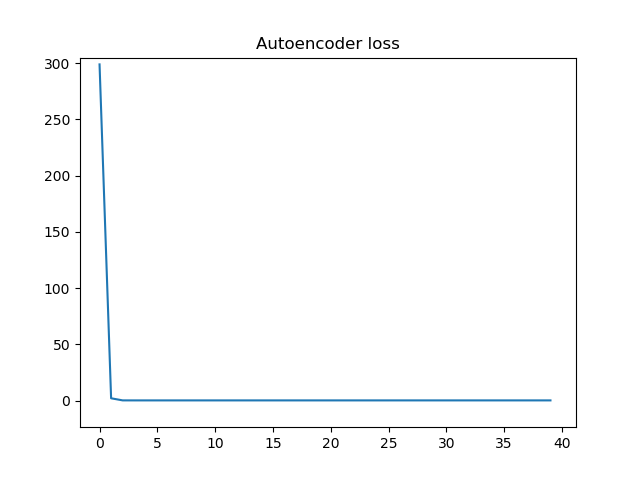

In [18]:
%matplotlib notebook  
%matplotlib notebook  
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Autoencoder loss")
plt.show()

In [19]:
torch.save(model.state_dict(), 'autoencoder-06-11-2019-model.pth')

### Evaluation

In [ ]:
model.load_state_dict(torch.load('autoencoder-basic-model.pth'))

In [29]:
with torch.no_grad():
    for data in tqdm(tensor_data.squeeze(0)):
        X = data.unsqueeze(0).to(device)
        output = model.encoder(X)

100%|██████████| 4529/4529 [00:04<00:00, 1077.02it/s]


In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='mnist', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='mnist', train=False,
                                  download=False, transform=transform)

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim).to(device)
print(model)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 20


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1).to(device)
        print(images.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        print(images.size(0))
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))